使用Wasserstein生成Dog and Cat数据
===

# 1.全局设置

In [25]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_ROOT = "/input/DogsAndCats"
NOISE_DIM = 100
IMAGE_SIZE = 128
IMAGE_CHANNEL = 3
BATCH_SIZE = 64
EPOCHS = 100
CLAMP_NUM = 0.01
LEARNING_RATE=5e-5

In [26]:
def weight_init(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, torch.nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

# 2.模型

In [27]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 64 * 16, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 16),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 8),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 4),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 2,64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )

        self.deconv6 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64,IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        weight_init(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        output = self.deconv6(output)
        return output

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 2),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 4),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 8),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 8, 64 * 16, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(num_features=64 * 16),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.conv6 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 16, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

        weight_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = self.conv6(output)
        output = output.mean(0).view(1)

        return output

# 3.导入数据

(331, 464, 3)


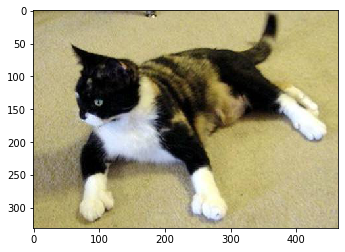

In [28]:
img = Image.open(os.path.join(DATA_ROOT,'train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [31]:
if not os.path.exists(os.path.join(DATA_ROOT, 'test')):
    os.mkdir(os.path.join(DATA_ROOT, 'test'))

if not os.path.exists(os.path.join(DATA_ROOT, 'valid')):
    os.mkdir(os.path.join(DATA_ROOT, 'valid'))
    
for fname in os.listdir(os.path.join(DATA_ROOT, 'train')):
    if not fname.endswith('.jpg'):
        continue
    _, img_num, _ = fname.split('.')
    filepath = os.path.join(DATA_ROOT, 'train', fname)
    img_num = int(img_num)
    if img_num > 11249:
        os.rename(filepath, filepath.replace('train', 'test'))
    elif img_num > 9999:
        os.rename(filepath, filepath.replace('train', 'valid'))

In [32]:
NetD = Discriminator()
NetG = Generator()

optimizerD = torch.optim.RMSprop(NetD.parameters(), lr=LEARNING_RATE)
optimizerG = torch.optim.RMSprop(NetG.parameters(), lr=LEARNING_RATE)

trans = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) ,
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5] * 3, [0.5] * 3)
                               ])
dataset = tv.datasets.ImageFolder(root=DATA_PATH, transform=trans)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

one=torch.FloatTensor([1])
mone = -1 * one
one_var  = torch.autograd.Variable(one)
mone_var = torch.autograd.Variable(mone)

fix_noise     = torch.FloatTensor(100, NOISE_DIM, 1, 1).normal_(0,1)
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    one_var = one_var.cuda()
    mone_var = mone_var.cuda()
    fix_noise_var = fix_noise_var.cuda()

# 4.训练

In [ ]:
showbar = bar.ProgressBar(EPOCHS, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCHS + 1):
    for index, (image, label) in enumerate(train_loader):
        real  = image
        real_var = torch.autograd.Variable(real)
        noise = torch.randn(real_var.size(0),NOISE_DIM,1,1)
        noise_var = torch.autograd.Variable(noise)

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()

        for parm in NetD.parameters():
            parm.data.clamp_(-CLAMP_NUM, CLAMP_NUM)

        NetD.zero_grad()
        D_real=NetD(real_var)
        D_real.backward(one_var)

        fake_pic=NetG(noise_var).detach()
        D_fake=NetD(fake_pic)
        D_fake.backward(mone_var)
        optimizerD.step()

        G_ = D_fake
        if (index+1)%5 ==0:
            NetG.zero_grad()
            noise.data.normal_(0,1)
            fake_pic=NetG(noise_var)
            G_=NetD(fake_pic)
            G_.backward(one_var)
            optimizerG.step()
            if index%100==0:
                pass
        showbar.show(epoch, D_fake.item(), G_.item())

# 5.生成

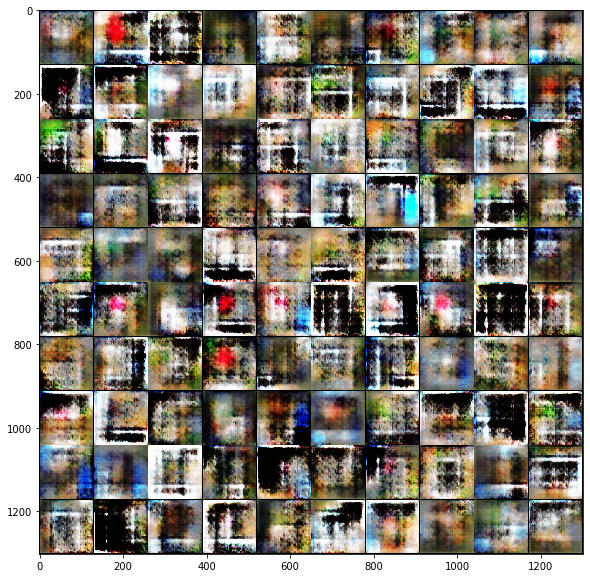

In [36]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))